In [1]:
%pylab inline
random.seed(2019)

Populating the interactive namespace from numpy and matplotlib


simulating  5.787037037037037  days of running.
[4.51741107e+11 1.96540253e+11 3.11984981e+11 ... 2.90347122e+11
 1.42557615e+11 3.88187372e+11]


(1.0, 10000.0)

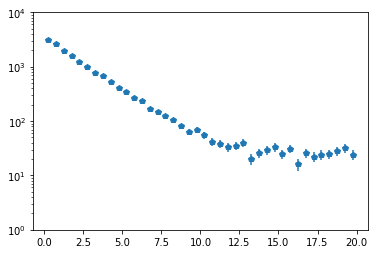

In [2]:
R_MUON  = 10*1E-6   # muons / microsecond 
WINDOW  = 20        # microseconds
F_DECAY = 0.0030      # fraction that decay
N_MUON  = 5000000
TAU     = 2.15

HW_PED   = 10
HW_SCALE = 0.0061  # microseconds
HW_MAX   = 2**12 - 1
HW_NOISE = 2.0
HW_SYST  = 1.0

TOTAL   =  N_MUON / R_MUON           # total time in micro-seconds
DAYS    = TOTAL / 1E6 / 60.0 / 60.0 / 24.0 # total time in days
print("simulating ", DAYS, " days of running.")


times  = random.uniform(0,TOTAL,size=N_MUON)
x      = random.uniform(0,1.0,size=N_MUON)
decays = (x < F_DECAY)
print(times)

decay_times = times[decays]
decay_times = decay_times + random.exponential(scale=TAU, size=size(decay_times))

times = np.sort(np.append(times, decay_times))

deltas = times[1:] - times[:-1]

h,edges = np.histogram(deltas,bins=40,range=(0,20.0))
unc = h**0.5
cbins = (edges[1:] + edges[:-1])/2.0 
plt.errorbar(cbins,h,yerr=unc,fmt="p")
plt.yscale('log')
plt.ylim(1.0,1E4)





[4095. 4095. 4095. 4095. 4095. 4095. 4095. 4095. 4095. 4095.]


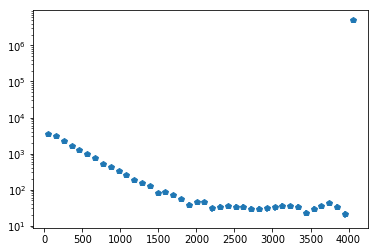

In [3]:
hw_deltas = HW_PED + deltas / HW_SCALE + random.normal(HW_NOISE, size=size(deltas))

hw_deltas[(hw_deltas > HW_MAX)] = HW_MAX


h,edges = np.histogram(hw_deltas,bins=40,range=(0,HW_MAX+10))
unc = h**0.5
cbins = (edges[1:] + edges[:-1])/2.0 
plt.errorbar(cbins,h,yerr=unc,fmt="p")
plt.yscale('log')
#plt.ylim(1.0,1E4)

print(hw_deltas[0:10])
np.save("cosmics.npy", hw_deltas)


In [4]:
dts    = np.array([1.0,2.0,4.0, 8.0])
for dt in dts:
    hw = dt / HW_SCALE + HW_PED + random.normal(HW_SYST)    
    samp = random.normal(loc=hw, scale=HW_NOISE, size=1000)
    np.save("pulser_"+str(int(dt))+".npy",samp)


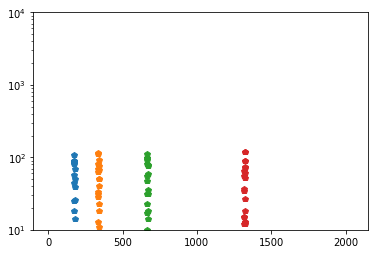

In [5]:
dts    = np.array([1.0,2.0,4.0, 8.0])
for dt in dts:
    samp  = np.load("pulser_"+str(int(dt))+".npy")
    h,edges = np.histogram(samp,bins=2**12,range=(0,HW_MAX/2))
    cbins = (edges[1:] + edges[:-1])/2.0 
    plt.plot(cbins,h,"p")
    plt.yscale('log')
    plt.ylim(10,10000)

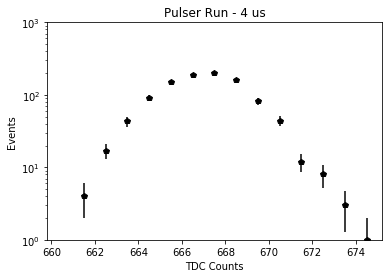

In [11]:
samp  = np.load("pulser_4.npy")
h,edges = np.histogram(samp,bins=15,range=(660,675))
cbins = (edges[1:] + edges[:-1])/2.0 
unc = h**0.5
plt.errorbar(cbins,h,yerr=unc,fmt="kp")
plt.yscale('log')
plt.ylim(1,1000)
plt.ylabel("Events")
plt.xlabel("TDC Counts")
plt.title("Pulser Run - 4 us")
plt.savefig("pulser_4_raw.pdf")

In [7]:
from scipy import optimize

def linear_func(x, a, b):
    return a*x + b


means  = np.array([])
dmeans = np.array([])

for dt in dts:
    samp  = np.load("pulser_"+str(dt)+".npy")
    mean  = np.mean(samp)
    dmean = np.var(samp)**0.5 / sqrt(size(samp))    
    print("mean:  ", mean, " +/- ", dmean)
    means = np.append(means,mean)
    dmeans = np.append(dmeans,dmean)
    


mean:   263.924  +/-  0.06404860654221917
mean:   429.097  +/-  0.06325812991228875
mean:   756.896  +/-  0.06430539635209473
mean:   1411.135  +/-  0.06298233879430012


hw_scale:   0.00610434273199414
hw_ped:   100.94513011658707


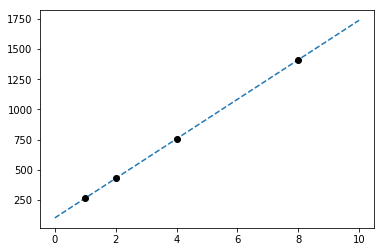

In [8]:

plt.errorbar(dts,means,yerr=dmeans,fmt="ko")    

par, cov = optimize.curve_fit(linear_func, dts, means, sigma=dmeans,absolute_sigma=True, p0=[1.0, 0.0])

hw_scale = 1.0/par[0]
hw_ped   = par[1]    

xf = np.linspace(0,10,100)
yf = linear_func(xf, par[0],par[1])
plt.plot(xf,yf,"--",label="fit")
print("hw_scale:  ", hw_scale)
print("hw_ped:  ", hw_ped)




[24.38107982 24.38107982 24.38107982 ... 24.38107982 24.38107982
 24.38107982]
measured muon lifetime:   2.1589854860433597 +/- 0.026086111978626064


Text(0.5,0,'Time [microseconds]')

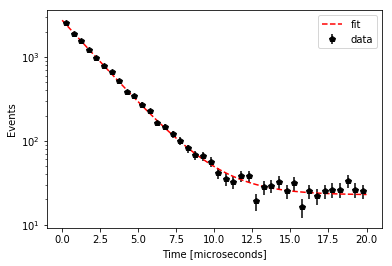

In [9]:
hw_deltas = np.load("cosmics.npy")
deltas = (hw_deltas - hw_ped) * hw_scale
print(deltas)

h,edges = np.histogram(deltas,bins=40,range=(0,20.0))
unc = h**0.5
cbins = (edges[1:] + edges[:-1])/2.0 
plt.errorbar(cbins,h,yerr=unc,fmt="kp",label="data")
plt.yscale('log')
#plt.ylim(1.0,1E4)

def exp_func(x, a, b, c):
    return a*exp(-x/b) + c

par, cov = optimize.curve_fit(exp_func, cbins,h, sigma=unc,absolute_sigma=True, p0=[1E3, 2.0,0])
unc = (np.diag(cov))**0.5

print("measured muon lifetime:  ", par[1], "+/-", unc[1])


xf = np.linspace(0,20.0,100)
yf = exp_func(xf,par[0],par[1],par[2])
plt.plot(xf,yf,"r--",label="fit")
plt.legend()
plt.ylabel("Events")
plt.xlabel("Time [microseconds]")


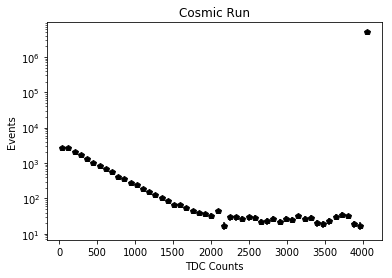

In [10]:
hw_deltas = np.load("cosmics.npy")
h,edges = np.histogram(hw_deltas,bins=50,range=(0,HW_MAX))
unc = h**0.5
cbins = (edges[1:] + edges[:-1])/2.0 
plt.errorbar(cbins,h,yerr=unc,fmt="kp",label="data")
plt.yscale('log')
plt.ylabel("Events")
plt.xlabel("TDC Counts")
plt.title("Cosmic Run")
plt.savefig("cosmics_raw.pdf")